
      * Linear regression with visit_month and target data only. *
    
Visit_month seems to have a very low correlation with the targets, but it is what we got.

I created 4 models, one per target variable. I tried other models as well, such as XGBoost, and didn't see any improvements.

The one thing I do see that improves smape is to **drop target variables that are NAs**.

Also, making uprds_4 results = 0 for all entries seems to be the best approach. Furthermore, dropping all updrs_3 == 0 from training improve results!

That is the best I got so far!


In [1]:
import amp_pd_peptide

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import optuna
import re
import sklearn
import math
import gc
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import lightgbm as lgb
import scipy.stats
from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn import ensemble
import matplotlib.pyplot as plt
import optuna
plt.style.use('fivethirtyeight') 

from tensorflow.keras import layers, models

from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV, LeaveOneOut
from sklearn.preprocessing import *
from sklearn.svm import SVR
from optuna.visualization import plot_slice
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import *
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsRegressor

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from optuna.integration import XGBoostPruningCallback

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [3]:
DATA_PATH = '../input/amp-parkinsons-disease-progression-prediction/'
targets = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
proteins = pd.read_csv(DATA_PATH + "train_proteins.csv")
proteins_test = pd.read_csv(DATA_PATH + "example_test_files/test_proteins.csv")
supplemental = pd.read_csv(DATA_PATH + "supplemental_clinical_data.csv")
peptides = pd.read_csv(DATA_PATH + "train_peptides.csv")
peptides_test = pd.read_csv(DATA_PATH + "example_test_files/test_peptides.csv")
clinical =  pd.read_csv(DATA_PATH + "train_clinical_data.csv")
test_data = pd.read_csv(DATA_PATH + "/example_test_files/test.csv")
sample= pd.read_csv(DATA_PATH + "example_test_files/sample_submission.csv")

In [4]:
def range_diff(x):
    return x.max() - x.min()

def k_stat(x):
    return scipy.stats.kstat(x)

def kurt(x):
    return scipy.stats.kurtosis(x)

def skew(x):
    return scipy.stats.skew(x)

In [5]:
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    y_true = y_true + 1
    y_pred = y_pred + 1
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = numer / (denom/2)
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape


def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true) + 1, np.array(y_pred) + 1
    
    numer = np.round(np.abs(y_pred-y_true),0)
    denom = np.round(np.abs(y_true) + np.abs(y_pred),0)

    return 1/len(y_true) * np.sum(np.nan_to_num(numer / (denom/2))) *100

In [6]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):

    """
    Calculate symmetric mean absolute percentage error from given ground-truth and predictions
    
    Parameters
    ----------
    y_true: array-like of shape (n_samples)
        Array of ground-truth values
        
    y_pred: array-like of shape (n_samples)
        Array of prediction values
        
    Returns
    -------
    smape: float
        Symmetric mean absolute percentage error
    """

    smape = 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    return smape


def score(df, target_columns, prediction_columns):
    
    """
    Concatenate targets and prediction into a single array and calculate SMAPE + 1
    
    Parameters
    ----------
    target_columns: list of shape (4)
        Array of target column names
        
    prediction_columns: list of shape (4)
        Array of prediction column names
        
    Returns
    -------
    score: float
        Symmetric mean absolute percentage error
    """
    
    y_true = []
    y_pred = []
    
    for target_column, prediction_column in zip(target_columns, prediction_columns):
        target_idx = df[target_column].notna()
        y_true.append(df.loc[target_idx, target_column].values + 1)
        y_pred.append(df.loc[target_idx, prediction_column].values + 1)
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
        
    score = symmetric_mean_absolute_percentage_error(
        y_true=y_true,
        y_pred=y_pred
    )
    
    return score

In [7]:
def smape_10(y_true, y_pred):
    return smape(y_true + 10, y_pred + 10)

# Read Data

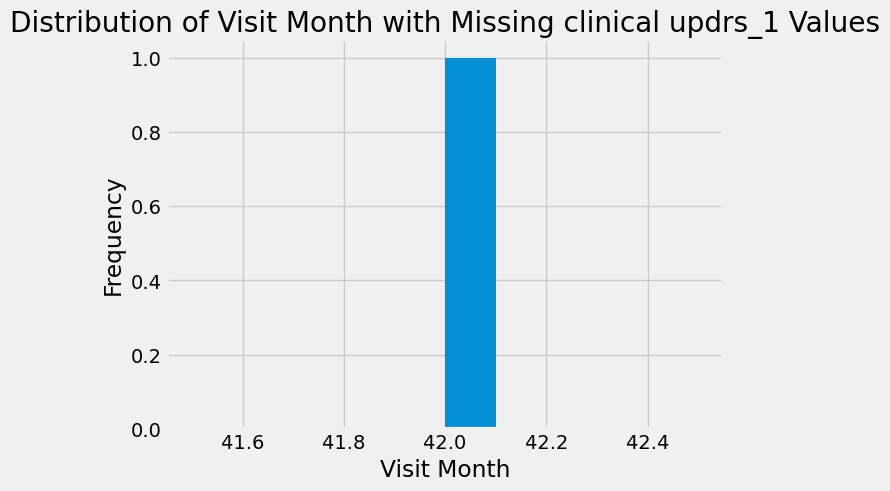

In [8]:
# updrs_1 の欠損値がある行を抽出
missing_updrs_1 = clinical[clinical['updrs_1'].isnull()]

# visit_month 列の分布を表示
missing_updrs_1['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing clinical updrs_1 Values')
plt.show()

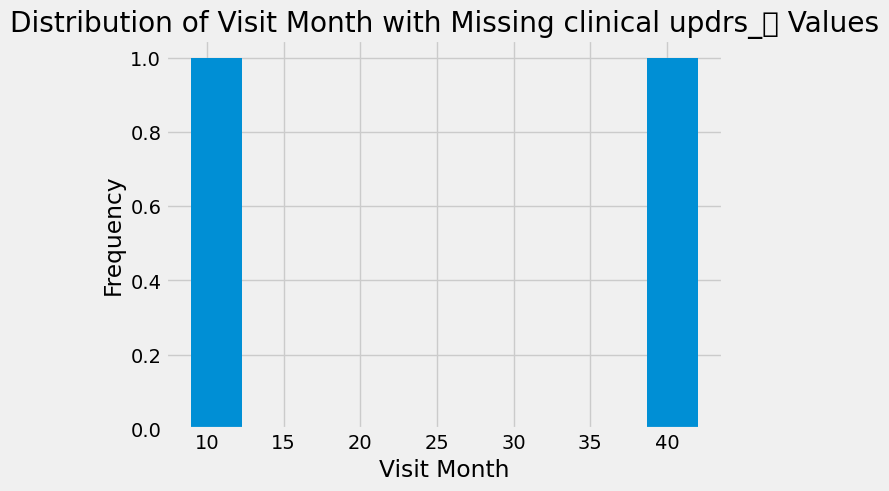

In [9]:
# updrs_２ の欠損値がある行を抽出
missing_updrs_２ = clinical[clinical['updrs_2'].isnull()]

# visit_month 列を表示
missing_updrs_２['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing clinical updrs_２ Values')
plt.show()

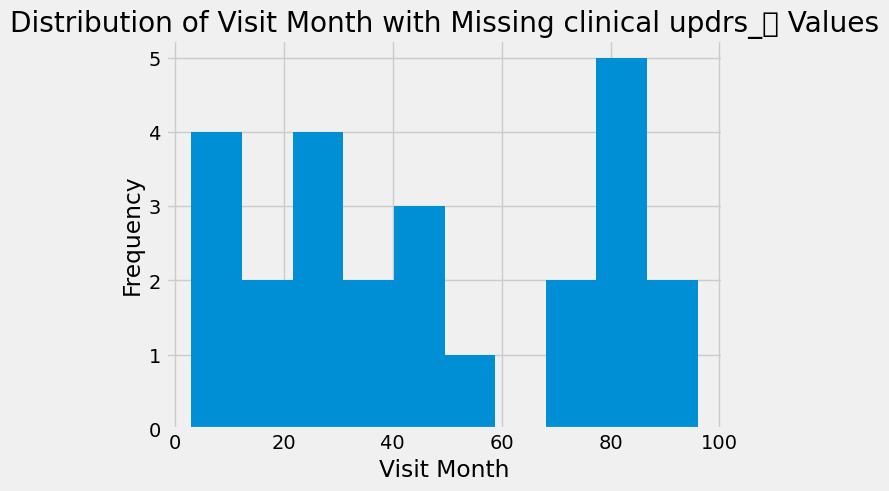

In [10]:
# updrs_３ の欠損値がある行を抽出
missing_updrs_３ = clinical[clinical['updrs_3'].isnull()]

# visit_month 列を表示
missing_updrs_3['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing clinical updrs_３ Values')
plt.show()

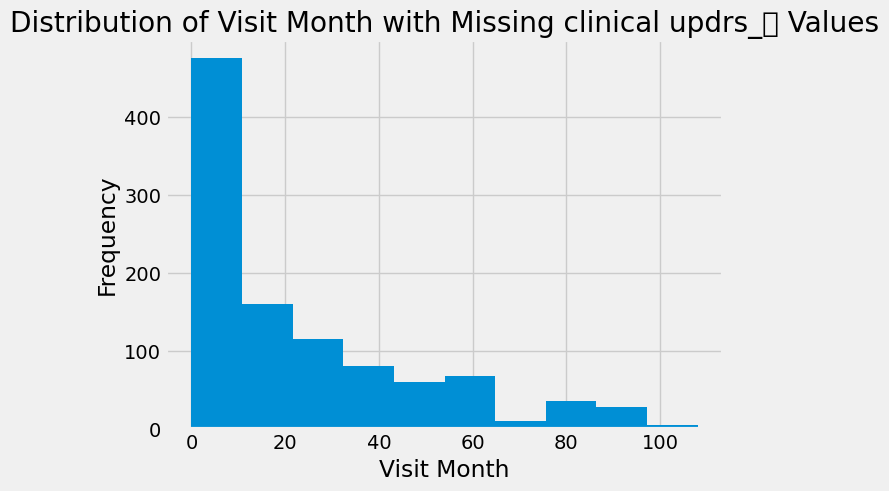

In [11]:
# updrs_4 の欠損値がある行を抽出
missing_updrs_4 = clinical[clinical['updrs_4'].isnull()]

# visit_month 列を表示
missing_updrs_4['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing clinical updrs_４ Values')
plt.show()

In [12]:
supplemental.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [13]:
# データの確認（服薬状態の一意な要素について）
state_on_medication_unique_elements_supplemental = [supplemental['upd23b_clinical_state_on_medication'].unique()]
print(state_on_medication_unique_elements_supplemental)

[array([nan, 'On', 'Off'], dtype=object)]


In [14]:
# データの確認（服薬状態の一意な要素について）
state_on_medication_unique_elements_clinical = [clinical['upd23b_clinical_state_on_medication'].unique()]
print(state_on_medication_unique_elements_clinical )

[array([nan, 'On', 'Off'], dtype=object)]


In [15]:
# visit_id列に基づいて重複する行を特定
duplicated_clinical_rows = clinical[clinical.duplicated(subset=['visit_id'], keep=False)]

# 重複する行を表示
print(duplicated_clinical_rows)

Empty DataFrame
Columns: [visit_id, patient_id, visit_month, updrs_1, updrs_2, updrs_3, updrs_4, upd23b_clinical_state_on_medication]
Index: []


In [16]:
# visit_id列に基づいて重複する行を特定
duplicated_supplemental_rows = supplemental[supplemental.duplicated(subset=['visit_id'], keep=False)]

# 重複する行を表示
print(duplicated_supplemental_rows)

Empty DataFrame
Columns: [visit_id, patient_id, visit_month, updrs_1, updrs_2, updrs_3, updrs_4, upd23b_clinical_state_on_medication]
Index: []


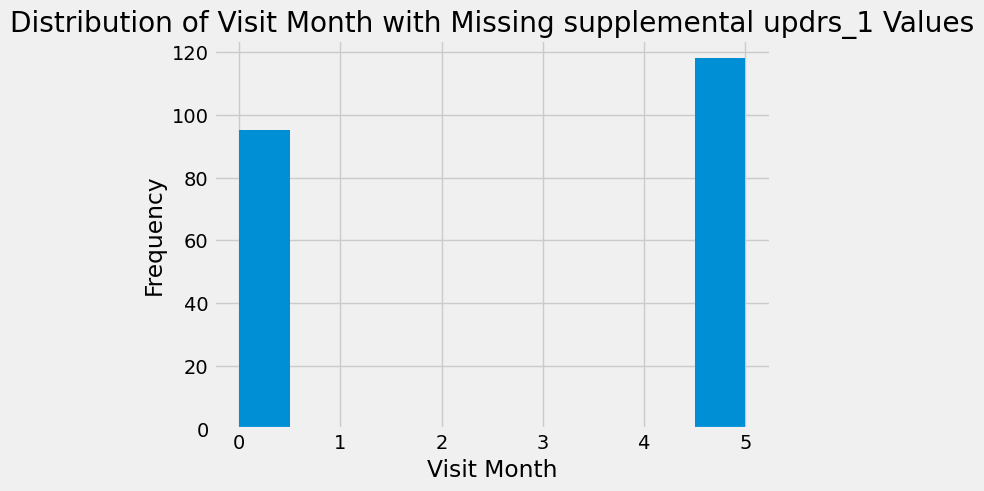

In [17]:
# updrs_1 の欠損値がある行を抽出
missing_updrs_1 = supplemental[supplemental['updrs_1'].isnull()]

# visit_month 列の分布を表示
missing_updrs_1['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing supplemental updrs_1 Values')
plt.show()

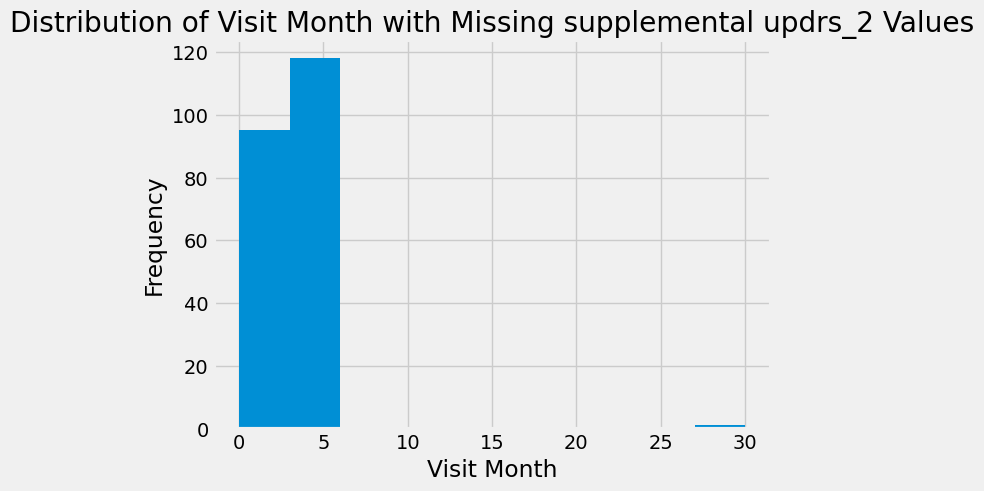

In [18]:
# updrs_２ の欠損値がある行を抽出
missing_updrs_２ = supplemental[supplemental['updrs_2'].isnull()]

# visit_month 列を表示
missing_updrs_２['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing supplemental updrs_2 Values')
plt.show()

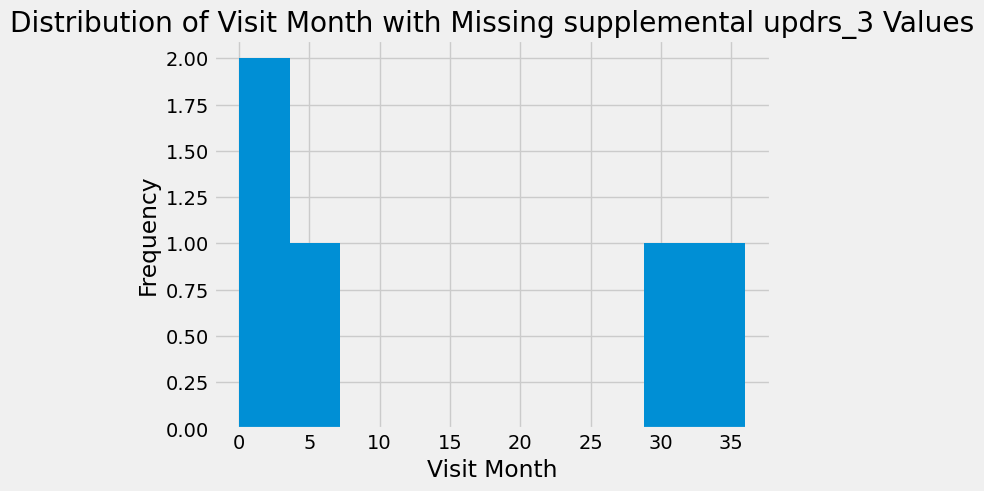

In [19]:
# updrs_３ の欠損値がある行を抽出
missing_updrs_３ = supplemental[supplemental['updrs_3'].isnull()]

# visit_month 列を表示
missing_updrs_3['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing supplemental updrs_3 Values')
plt.show()

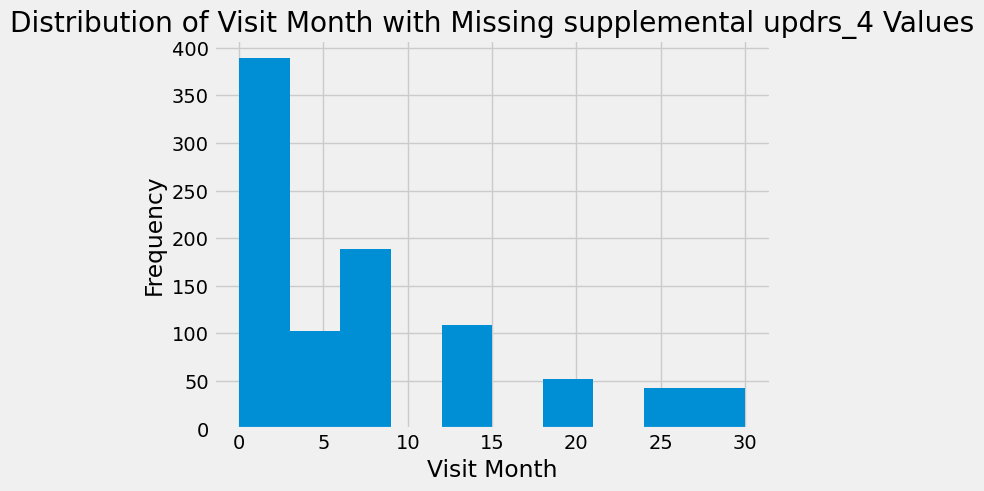

In [20]:
# updrs_4 の欠損値がある行を抽出
missing_updrs_4 = supplemental[supplemental['updrs_4'].isnull()]

# visit_month 列を表示
missing_updrs_4['visit_month'].hist()
plt.xlabel('Visit Month')
plt.ylabel('Frequency')
plt.title('Distribution of Visit Month with Missing supplemental updrs_4 Values')
plt.show()

In [21]:
# データの確認（訪問月の一意な要素について）
unique_elements = [supplemental['visit_month'].unique()]
print(unique_elements)

[array([ 0, 36,  5,  6, 12, 18, 24, 30])]


In [22]:
# データの確認（訪問月の一意な要素について）
unique_elements = [clinical['visit_month'].unique()]
print(unique_elements)

[array([  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60,
        72,  84,  96, 108])]


In [23]:
# 変数clinicallの訪問月5の削除
# clinical = clinical[clinical['visit_month'] != 5]

# インデックスをリセットして振り直す
# clinical.reset_index(drop=True, inplace=True)
# clinical.head()

In [24]:
# 欠損値確認
supplemental.isna().sum()/len(supplemental)

visit_id                               0.000000
patient_id                             0.000000
visit_month                            0.000000
updrs_1                                0.095816
updrs_2                                0.096266
updrs_3                                0.002249
updrs_4                                0.417454
upd23b_clinical_state_on_medication    0.495277
dtype: float64

In [25]:
# データの確認（訪問月の一意な要素について）
clinical_visit_month_unique_elements = [clinical['visit_month'].unique()]

In [26]:
# 欠損値確認
clinical.isna().sum()/len(clinical)

visit_id                               0.000000
patient_id                             0.000000
visit_month                            0.000000
updrs_1                                0.000382
updrs_2                                0.000765
updrs_3                                0.009560
updrs_4                                0.396941
upd23b_clinical_state_on_medication    0.507457
dtype: float64

In [27]:
# 見てみる
median_updrs_1 = clinical['updrs_1'].median()
clinical['updrs_1'].fillna(median_updrs_1, inplace=True)
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [28]:
# median_updrs_1 = clinical[(clinical['visit_month'] >= 30) & (clinical['visit_month'] <= 40)]['updrs_1'].median()
# clinical['updrs_1'].fillna(median_updrs_1, inplace=True)

# median_updrs_2 = clinical[(clinical['visit_month'] >= 0) & (clinical['visit_month'] <= 12)]['updrs_2'].median()
# clinical['updrs_2'].fillna(median_updrs_2, inplace=True)

# 3についてはもっと細かく欠損値補完する予定
# clinical['updrs_3'].fillna(clinical['updrs_3'].median(), inplace=True)

# clinical['updrs_4'].fillna(clinical['updrs_4'].median(), inplace=True)

In [29]:
def process_medication_data(df, medication_status):
    medication_data = df[df['upd23b_clinical_state_on_medication'] == medication_status]

    # updrs列の中央値を計算
    median_updrs_1 = medication_data['updrs_1'].median()
    median_updrs_2 = medication_data['updrs_2'].median()
    median_updrs_3 = medication_data['updrs_3'].median()
    median_updrs_4 = medication_data['updrs_4'].median()

    # 欠損値を中央値で補完
    medication_data['updrs_1'].fillna(median_updrs_1, inplace=True)
    medication_data['updrs_2'].fillna(median_updrs_2, inplace=True)
    medication_data['updrs_3'].fillna(median_updrs_3, inplace=True)
    medication_data['updrs_4'].fillna(median_updrs_4, inplace=True)

    return medication_data

# on_medication_clinical = process_medication_data(clinical, 'On')
# off_medication_clinical = process_medication_data(clinical, 'Off')

# on_medication_supplemental = process_medication_data(supplemental, 'On')
# off_medication_supplemental = process_medication_data(supplemental, 'Off')

In [30]:
# clinical = on_medication_clinical.append(off_medication_clinical, ignore_index=True)
# supplemental = on_medication_supplemental.append(off_medication_supplemental, ignore_index=True)

In [31]:
# データの結合状態の確認
# clinical.head()

In [32]:
# 欠損値確認
# clinical.isna().sum()/len(clinical)

In [33]:
# データの結合状態の確認
# supplemental.head()

In [34]:
# 欠損値確認
# supplemental.isna().sum()/len(supplemental)

In [35]:
# 不要列の削除
del clinical['upd23b_clinical_state_on_medication']
del supplemental['upd23b_clinical_state_on_medication']

In [36]:
# 欠損値を中央値で補完
supplemental['updrs_1'].fillna(supplemental['updrs_1'].median(), inplace=True)
supplemental['updrs_2'].fillna(supplemental['updrs_2'].median(), inplace=True)
supplemental['updrs_3'].fillna(supplemental['updrs_3'].median(), inplace=True)
supplemental['updrs_4'].fillna(supplemental['updrs_4'].median(), inplace=True)

# 欠損値を中央値で補完
clinical['updrs_1'].fillna(clinical['updrs_1'].median(), inplace=True)
clinical['updrs_2'].fillna(clinical['updrs_2'].median(), inplace=True)
clinical['updrs_3'].fillna(clinical['updrs_3'].median(), inplace=True)
clinical['updrs_4'].fillna(clinical['updrs_4'].median(), inplace=True)

In [37]:
# データの確認（欠損値の削除の正常完了の確認）
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0


In [38]:
clinical['visit_id'] = clinical['visit_id'].astype('O')

In [39]:
# オブジェクト型（dtype('O')）への変換完了の確認
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0


In [40]:
# 欠損値確認
clinical.isna().sum()/len(clinical)

visit_id       0.0
patient_id     0.0
visit_month    0.0
updrs_1        0.0
updrs_2        0.0
updrs_3        0.0
updrs_4        0.0
dtype: float64

In [41]:
# データの確認
supplemental.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,35_0,35,0,5.0,3.0,16.0,0.0
1,35_36,35,36,6.0,4.0,20.0,0.0
2,75_0,75,0,4.0,6.0,26.0,0.0
3,75_36,75,36,1.0,8.0,38.0,0.0
4,155_0,155,0,5.0,5.0,0.0,0.0


In [42]:
# 欠損値確認
supplemental.isna().sum()/len(supplemental)

visit_id       0.0
patient_id     0.0
visit_month    0.0
updrs_1        0.0
updrs_2        0.0
updrs_3        0.0
updrs_4        0.0
dtype: float64

In [43]:
# clinical = clinical.append(supplemental, ignore_index=True)

In [44]:
# データの確認
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0


In [45]:
# 欠損値確認
clinical.isna().sum()/len(clinical)

visit_id       0.0
patient_id     0.0
visit_month    0.0
updrs_1        0.0
updrs_2        0.0
updrs_3        0.0
updrs_4        0.0
dtype: float64

In [46]:
# データの確認
supplemental.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,35_0,35,0,5.0,3.0,16.0,0.0
1,35_36,35,36,6.0,4.0,20.0,0.0
2,75_0,75,0,4.0,6.0,26.0,0.0
3,75_36,75,36,1.0,8.0,38.0,0.0
4,155_0,155,0,5.0,5.0,0.0,0.0


In [47]:
# 欠損値確認
supplemental.isna().sum()/len(supplemental)

visit_id       0.0
patient_id     0.0
visit_month    0.0
updrs_1        0.0
updrs_2        0.0
updrs_3        0.0
updrs_4        0.0
dtype: float64

In [48]:
# データを確認
proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [49]:
# 欠損値確認
proteins.isna().sum()/len(proteins)

visit_id       0.0
visit_month    0.0
patient_id     0.0
UniProt        0.0
NPX            0.0
dtype: float64

In [50]:
# データを確認
peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [51]:
# 欠損値確認
peptides.isna().sum()/len(clinical)

visit_id            0.0
visit_month         0.0
patient_id          0.0
UniProt             0.0
Peptide             0.0
PeptideAbundance    0.0
dtype: float64

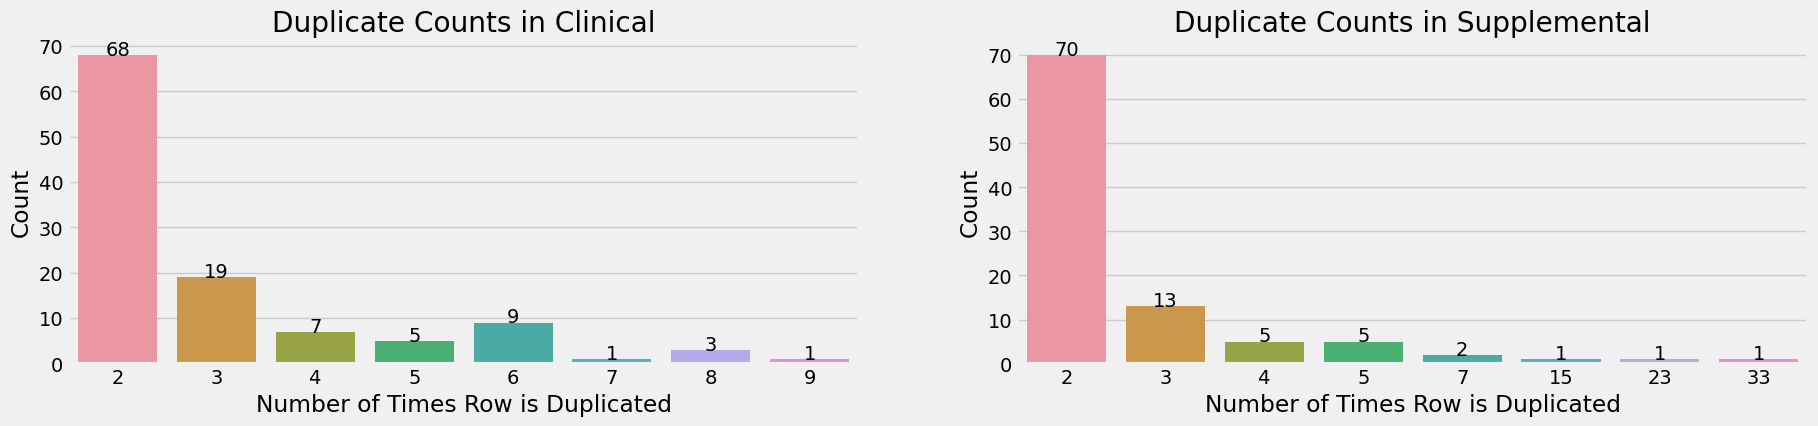

In [52]:
titles = ["Clinical", "Supplemental"]
value_counts = []

duplicates = clinical.pivot_table(index=[
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

duplicates = supplemental.pivot_table(index=[
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs = axs.flatten()

for x in range(2):
    ax = axs[x]
    _ = sns.barplot(x=list(value_counts[x].keys())[1:], y=list(value_counts[x].values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in {}".format(titles[x], fontsize=15))
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("Number of Times Row is Duplicated")
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+(p.get_width()/2), y=height, s="{:d}".format(int(height)), ha="center")

# Train Model

In [53]:
model = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

for u in target:
        
    # Drop NAs
    temp = clinical.dropna(subset=[u]) 
    
    # For updrs_3, dropping 0's improve results
    if u == 'updrs_3':
        temp = temp[temp[u] != 0]
        
    # Train data
    X = temp['visit_month']
    y = temp[u]
        
    trained = LinearRegression().fit(X.values.reshape(-1, 1), y)
    
    # Save model
    model[u] = trained

In [54]:
def get_predictions(my_train, model):

    # Forecast
    my_train = my_train.fillna(0)
    
    for u in target:
        
        # Here is where we will save the final results
        my_train['result_' + str(u)] = 0
  
        # Predict    
        X = my_train["visit_month"]
        
        # updrs_4 will have only 0's, so we update for others
        if u != 'updrs_4':
            my_train['result_' + str(u)] = model[u].predict(X.values.reshape(-1, 1))

        
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = my_train[["visit_id", "result_updrs_" + str(u)]]
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

# Run once to check results
get_predictions(clinical, model)

,prediction_id,rating
0,55_0_updrs_1_plus_0_months,6.278644
1,55_3_updrs_1_plus_0_months,6.358619
2,55_6_updrs_1_plus_0_months,6.438593
3,55_9_updrs_1_plus_0_months,6.518568
4,55_12_updrs_1_plus_0_months,6.598542
...,...,...
2610,65043_48_updrs_4_plus_24_months,0.000000
2611,65043_54_updrs_4_plus_24_months,0.000000
2612,65043_60_updrs_4_plus_24_months,0.000000
2613,65043_72_updrs_4_plus_24_months,0.000000


In [55]:
# メモリクリア
gc.collect()

27973

# Predict

In [56]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = dem != 0
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [57]:
# Set the total value 
bar = tqdm(total = 100)
# Add description
bar.set_description('Progress rate')
for i in range(100):
    # Set the progress
    bar.update(5)
    time.sleep(1)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.01911219]
0.5266284361940748


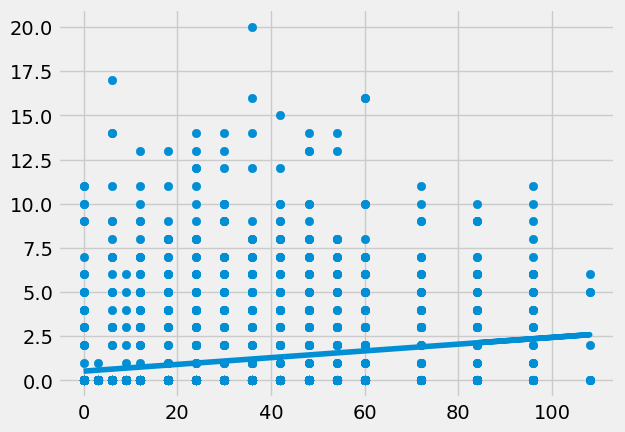

In [58]:
## 線形回帰の可視化
# 回帰係数
print(trained.coef_)

# 切片
print(trained.intercept_)

# 散布図
plt.scatter(X, y)

# Xデータを2次元に変換
X_2D = np.array(X).reshape(-1, 1)

# 回帰直線
plt.plot(X, trained.predict(X_2D))

# グラフの表示
plt.show()

# Default Code to Submit Answers

In [59]:
# メモリクリア
gc.collect()

3282

In [60]:
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [61]:
for (test, _, _, _) in iter_test:
        
    result = get_predictions(test, model)
    print(result.head())
    env.predict(result)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
                   prediction_id     rating
0   3342_0_updrs_1_plus_0_months   6.278644
4  50423_0_updrs_1_plus_0_months   6.278644
0   3342_0_updrs_2_plus_0_months   5.706929
4  50423_0_updrs_2_plus_0_months   5.706929
0   3342_0_updrs_3_plus_0_months  19.094674
                   prediction_id     rating
0   3342_6_updrs_1_plus_0_months   6.438593
4  50423_6_updrs_1_plus_0_months   6.438593
0   3342_6_updrs_2_plus_0_months   5.906089
4  50423_6_updrs_2_plus_0_months   5.906089
0   3342_6_updrs_3_plus_0_months  19.688759


In [62]:
estimates = {}
months = clinical.visit_month.unique()
targets = ['updrs_1','updrs_2', 'updrs_3', 'updrs_4']
test_list = [200, 150, 100, 50, 10, 5, 1, 0] #Intentionally leaving the best for last
best_test_val = 1000
best_test_score = 1000
df = pd.DataFrame()

for j in tqdm(test_list):
    for m in months:
        for target in targets:
            t = clinical[clinical.visit_month==m][f'{target}'].dropna().values
            if len(t) >= j:
                s = []
                best_threshold = 0
                best_smape = 200
                for i in np.arange(0, 50, 0.1):
                    score = smape(t, np.array([i for _ in range(len(t))]))
                    s.append(score)
                    if score < best_smape:
                        best_smape = score
                        best_threshold = i
            else:
                best_threshold = np.median(t)
            estimates[(m, target)] = best_threshold

    for i in range(int(sorted(months)[-1]) + 1):
        for target in targets:
            if (i, target) not in estimates:
                estimates[(i, target)] = estimates[(i-1, target)]
    
    validation_x = []
    validation_y = []

    for id, row in clinical.iterrows():
        for t in targets:
            if row[f'{t}']>=0:
                validation_x.append((row.visit_month, t))
                validation_y.append(row[f'{t}'])

    temp_score = smape(validation_y, pd.Series(validation_x).map(estimates).values)
    if temp_score <= best_test_score:
        best_test_score = temp_score
        best_test_val = j

  0%|          | 0/8 [00:00<?, ?it/s]

In [63]:
print(smape(validation_y, pd.Series(validation_x).map(estimates).values))

68.25696948651135


In [64]:
# print(smape_loss(validation_y, sub['rating']))

In [65]:
# print(calculate_smape(validation_y, sub[1]))

In [66]:
# print(symmetric_mean_absolute_percentage_error(validation_y, pd.Series(validation_x).map(estimates).values))

In [67]:
rmse = np.sqrt(mean_squared_error(validation_y, pd.Series(validation_x).map(estimates).values))
print(rmse)

8.887990049094942


* 8.005091522602465
* 7.81271861217854

In [68]:
# Set the total value 
bar = tqdm(total = 100)
# Add description
bar.set_description('Progress rate')
for i in range(100):
    # Set the progress
    bar.update(5)
    time.sleep(1)

  0%|          | 0/100 [00:00<?, ?it/s]